## Family Leave



In [249]:
%config Completer.use_jedi = False
import os
import pandas as pd
import numpy as np
os.chdir('/home/brian/Documents/CPS/data/clean/')

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-deep')
plt.rc('axes', axisbelow=True, edgecolor='whitesmoke')
plt.rc('ytick', labelsize=8, color='darkgray')
plt.rc('xtick', labelsize=9, color='dimgray')

# States and dates
sl = [('2004-01-01', '\nCA'),
      ('2009-01-01', '\nNJ'),
      ('2014-01-01', '\nRI'),
      ('2018-01-01', '\nNY'),
      ('2020-01-01', '\nDC\nWA'),
      ('2021-01-01', 'MA'),
      ('2022-01-01', '\nCT'),
      ('2023-09-01', 'OR'),
      ('2024-01-01', '\nCO'),
      ('2025-01-01', 'MD'),
      ('2026-01-01', '\nDE\nME\nMN')]

fdir = '/home/brian/Documents/blog_posts/Maternity_Paternity_Leave/'

### Collect data from CPS 

In [3]:
# Gather CPS data
cols = ['AGE', 'FEMALE', 'STATE', 'CPSID', 'FAMNUM', 'YEAR', 'MONTH',
        'ABSTYPE', 'PTREASON', 'NILFREASON', 'ABSPAID', 'PWSSWGT',
        'HRSACTT', 'LFS', 'PTECON', 'WORKFT', 'NLFFAM', 'FTLF']
a0 = lambda x: np.where(x.AGE == 0, 1, 0)
age0 = lambda x: x.groupby(['CPSID', 'FAMNUM']).A0.transform('sum')
mpleave = lambda x: np.where(x.ABSTYPE == 'Maternity/Paternity', 1, 0)
states = ['CA', 'NJ', 'RI', 'NY', 'WA', 'DC', 'CT', 'MA']
polstate = lambda x: np.where((x.STATE.isin(states)), 1, 0)
data = (pd.concat([pd.read_feather(f'cps{y}.ft', columns=cols)
                   .assign(A0 = a0, AGE0 = age0, POLSTATE = polstate, MPLEAVE = mpleave)
                   .drop(['A0'], axis=1)
                   .query('18 <= AGE <= 54') for y in range (1995, 2024)]))

data['DATE'] = pd.to_datetime(dict(year=data.YEAR, month=data.MONTH, day=1))

### Chart 1: Employed, not at work, maternity / paternity leave 

Share of adults age 18 to 54 in households containing an infant

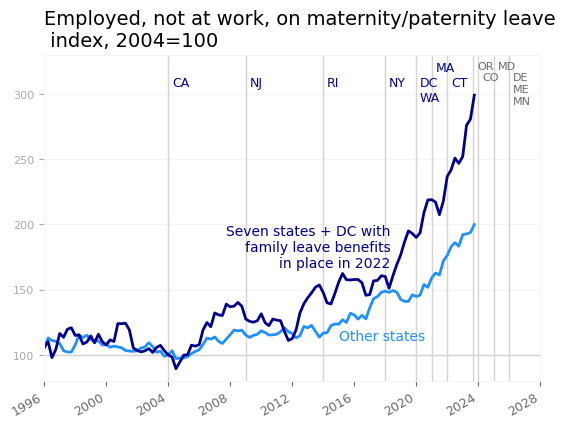

In [255]:
query = 'AGE0 > 0'
groupbycols = ['DATE', 'POLSTATE', 'MPLEAVE']
res = data.query(query).groupby(groupbycols).PWSSWGT.sum().unstack()
sh = ((res[1] / res.sum(axis=1)).unstack()
      .rolling(12).mean().resample('QS').mean())
shi = (sh / sh.loc['2004-01-01']) * 100
fig, ax = plt.subplots()
plt.axhline(y=100, color='lightgray', lw=1)
for date, name in sl:
    color = 'dimgray'
    size = 8
    dt = pd.to_datetime(date)
    if dt <= pd.to_datetime('2022-01-01'):
        color = 'darkblue'
        size = 9
    plt.axvline(x=dt, color='lightgray', lw=1)
    plt.annotate(name, xy=(dt + pd.DateOffset(months=3), 325), 
                 color=color, va='top', size=size)
shi.loc['1996':].plot(color=['dodgerblue', 'darkblue'], lw=2,
                      ylim=(80, 330), xlim=('1996', '2028'), 
                      legend=False, ax=ax)
ax.grid(axis='y', color='whitesmoke')
ax.set_xlabel('')
ax.set_title('Employed, not at work, on maternity/paternity leave\n index, 2004=100', 
             loc='left', size=14)
label1 = 'Seven states + DC with\nfamily leave benefits\nin place in 2022'
label2 = 'Other states'
plt.annotate(label1, xy=('2018-05-01', 200), 
             color='darkblue', va='top', ha='right', size=10, weight='medium')
plt.annotate(label2, xy=('2015-01-01', 120), 
             color='dodgerblue', va='top', ha='left', size=10, weight='medium')
plt.savefig(f'{fdir}leave.png', bbox_inches='tight')
plt.show()

### Chart 2: Women's Labor Force Participation Rate, with Infant

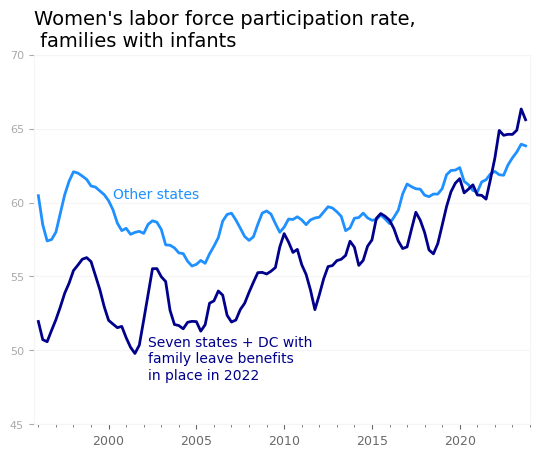

In [256]:
query = 'FEMALE == 1 and AGE0 > 0'
groupbycols = ['DATE', 'POLSTATE', 'LFS']
res = data.query(query).groupby(groupbycols).PWSSWGT.sum().unstack()
sh = (1 - (res['NILF'] / res.sum(axis=1)).unstack()
      .rolling(12).mean().resample('QS').mean())
sh = sh.loc['1996':] * 100

fig, ax = plt.subplots()
sh.loc['1996':].plot(color=['dodgerblue', 'darkblue'], lw=2,
                      ylim=(45, 70), xlim=('1995-12-01', '2024'), 
                      legend=False, ax=ax)
ax.grid(axis='y', color='whitesmoke')
ax.set_xlabel('')
ax.set_title("Women's labor force participation rate,\n families with infants", 
             loc='left', size=14)
label1 = 'Seven states + DC with\nfamily leave benefits\nin place in 2022'
label2 = 'Other states'
plt.annotate(label1, xy=('2002-05-01', 51), 
             color='darkblue', va='top', ha='left', size=10, weight='medium')
plt.annotate(label2, xy=('2000-05-01', 61), 
             color='dodgerblue', va='top', ha='left', size=10, weight='medium')
plt.savefig(f'{fdir}lfpr.png', bbox_inches='tight')
plt.show()

### Chart 3: Change in Women's LFP

In [247]:
d = {}
prdt = pd.date_range(start='1999-01-01', end='2000-12-01', freq='MS')
for name, grp in [('withinf', 'AGE0 > 0'), ('noinf', 'AGE0 == 0')]:
    query = f'FEMALE == 1 and {grp}'
    df = (data.query(query)
              .groupby(groupbycols).PWSSWGT.sum()
              .unstack())
    rt = (1 - (df['NILF'] / df.sum(axis=1))).unstack() * 100
    ltdt = df.unstack().index[-12:]
    # Calculate change
    d[name] = rt.loc[ltdt].mean() - rt.loc[prdt].mean()

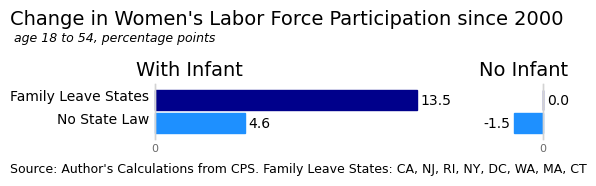

In [257]:
# Create chart
samples = [('With Infant', d['withinf'], 0, 'left'), 
           ('No Infant', d['noinf'], 20, 'center')]
cats = [('No State Law', 'dodgerblue', 0), 
        ('Family Leave States', 'darkblue', 1)]
fig, ax = plt.subplots(figsize=(7, 2))
ax.set_axis_off()
ax.set_ylim(-0.175, 0.5)
ax.set_xlim(-7.5, 20.5)
h = 0.09
title = "Change in Women's Labor Force Participation since 2000"
ax.text(-7.5, 0.475, title, ha='left', fontsize=14)
subtitle = "age 18 to 54, percentage points"
ax.text(-7.3, 0.4, subtitle, ha='left', fontsize=9, style='italic')
footer = "Source: Author's Calculations from CPS. Family Leave States: CA, NJ, RI, NY, DC, WA, MA, CT"
ax.text(-7.5, -0.175, footer, ha='left', fontsize=9)
for s, vals, offset, ha in samples:
    for name, color, idx in cats:
        ax.plot([offset, offset], [-0.025, 0.215], color='lightgray', lw=1)
        ax.add_patch(plt.Rectangle((0+offset, idx/10), 
                                   height=h, width=vals[idx], 
                                   color=color))
        hav = 'right' if vals[idx] < 0 else 'left'
        haoff = -0.2 if vals[idx] < 0 else 0.2
        ax.text(offset + vals[idx] + haoff, idx/10 + 0.025, 
                f'{vals[idx]:.1f}', ha=hav)
        if offset == 0:
            ax.text(-0.3, (idx/10) + 0.04, name, ha='right', fontsize=10)
    ax.text(offset - 1, 0.25, s, ha=ha, fontsize=14)
    ax.text(offset, -0.08, '0', ha='center', fontsize=8, color='dimgray')
plt.savefig(f'{fdir}overview.png', bbox_inches='tight')
plt.show()